# 数据处理

In [1]:
import os  
import pandas as pd  
import matplotlib.pyplot as plt
  
    #step1:加载数据集
# 设置数据集的路径  
data_dir = '/kaggle/input/110spm/110SPM/pressure'   
# 创建空的列表来存储所有的DataFrame  
X_data0 = []  
y_data0 = []
# 遍历指定目录下的所有文件  
for filename in os.listdir(data_dir):  
    if filename.endswith('.csv'):  
        # 构建文件的完整路径  
        file_path = os.path.join(data_dir, filename)  
        # 读取Excel文件  
        df = pd.read_csv(file_path)
        serie=df.iloc[:, 0]
        version_without_extension = filename.rsplit(".", 1)[0] 
        serie.name=version_without_extension
        # 将读取的DataFrame添加到列表中  
        X_data0.append(serie)
        y_data0.append(version_without_extension)

    #step2:遍历X_data0中的每个DataFrame，并删除非数字数据  
cleaned_data = []  
for df in X_data0:  
    df_cleaned = df[pd.to_numeric(df, errors='coerce').notnull()]  
    cleaned_data.append(df_cleaned)  
 

    #step3:将X_data0中的每个DataFrame的所有元素变为float类型 
for i, df in enumerate(cleaned_data):  
    X_data0[i] = df.astype(float) 

# 初始化X_data1来存储结果  
X_data1 = []  
  
# 遍历X_data0中的每个Series  
for series in X_data0:  
    # 计算步长（由于重叠率为50%，步长为序列长度的一半）  
    step_size = 256  # 因为512的一半是256，且我们想要50%的重叠  
    # 初始化一个空的list来存储子序列  
    subsequences = []  
    # 使用range和步长来生成子序列  
    for i in range(0, len(series) - 512 + 1, step_size):  
        # 确保切片是一维的，并转换为Series（虽然这里切片已经是Series）  
        subsequence = series.iloc[i:i+512]  
        subsequences.append(subsequence) 
    X_data1.append(subsequences)  
type(X_data1),len(X_data1),len(X_data1[0])

/tmp/ipykernel_17/1281161320.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/tmp/ipykernel_17/1281161320.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


(list, 12, 4213)

In [2]:
import subprocess  
# 使用subprocess.run()执行shell命令  
result = subprocess.run(['pip', 'install','EMD-signal'], capture_output=True, text=True)
import pandas as pd  
import numpy as np  
from PyEMD import EMD  #pip install EMD-signal
import matplotlib.pyplot as plt 
X_data2=[]
for sublist in X_data1:  
    X_data2_temp=[]
    for series0 in sublist: 
        X_EMD_test=series0.values
        emd = EMD()
        IMFs = emd.emd(X_EMD_test)  
        # 计算残差（原始信号减去所有IMF之和）  
        residual = X_EMD_test - np.sum(IMFs, axis=0)  
        # 计算相关性和方差贡献率  
        x=X_EMD_test
        N = len(x)  
        rho_xy = []  
        mesb = []  
        for y_i in IMFs:  
            # 计算均值  
            x_mean, y_mean = np.mean(x), np.mean(y_i)  
            # 计算相关性  
            cov_xy = np.sum((x - x_mean) * (y_i - y_mean))  
            var_x, var_y = np.sum((x - x_mean)**2), np.sum((y_i - y_mean)**2)  
            rho_xy_i = cov_xy / (np.sqrt(var_x) * np.sqrt(var_y))  
            rho_xy.append(rho_xy_i)  
      
            # 计算方差贡献率  
            d_i_squared = np.sum((y_i - y_mean)**2) / N  
            total_variance = sum(np.sum((imf - np.mean(imf))**2) / N for imf in IMFs)  
            mesb_i = d_i_squared / total_variance  
            mesb.append(mesb_i)  
  
        # 计算综合评价指标 K  
        alpha, beta = 0.2, 0.8  
        K = [alpha * rho + beta * mesb for rho, mesb in zip(rho_xy, mesb)]
        noise_imfs=[]
        non_noise_imfs=[]
        # 区分噪音和非噪音
        for i in range(len(K)):
            if K[i]< 0.1:
                noise_imfs.append(IMFs[i])
            else:
                non_noise_imfs.append(IMFs[i])
        # 重构信号  
        reconstructed_signal = np.sum(non_noise_imfs, axis=0) + residual
        series1=pd.Series(reconstructed_signal)
        series1.name=series0.name
        X_data2_temp.append(series1)
    X_data2.append(X_data2_temp)
len(X_data2),len(X_data2[0]),len(X_data2[0][0]),type(X_data2)

(12, 4213, 512, list)

In [3]:
import pandas as pd  
import numpy as np  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder  
from keras.utils import to_categorical
import time  
from keras.callbacks import Callback  
# 假设 X_data1 已经定义好了  
all_data = []  
all_labels = []  
  
for sublist in X_data2:  
    for series in sublist:  
        # 假设每个series是pandas Series  
        all_data.append(series.values)  
        all_labels.append(series.name)  
  
# 将数据转换为numpy数组  
data_array = np.array(all_data)  
# 将标签转换为编码  

label_encoder = LabelEncoder()  
labels_encoded = label_encoder.fit_transform(all_labels)  
  
# 如果需要one-hot编码  
labels_one_hot = to_categorical(labels_encoded)  
  
# 这里你可能需要reshape data_array 以符合LSTM的输入要求  
# LSTM通常要求输入形状为 (samples, time_steps, features)  
# 假设每个series的长度相同，或者你可以填充/截断它们以具有相同的长度  
time_steps = data_array.shape[1]  # 假设所有series长度相同  
data_array = data_array.reshape(-1, time_steps, 1)  # 增加一个维度以匹配LSTM的输入要求

# 分割数据集  
X_train, X_temp, y_train, y_temp = train_test_split(data_array, labels_one_hot, test_size=0.3, random_state=42)  
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

2024-07-09 05:18:34.349762: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 05:18:34.349953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 05:18:34.503174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 训练LSTM模型

In [4]:
from keras.models import Sequential  
from keras.layers import LSTM, Dense  
  
model = Sequential()  
model.add(LSTM(50, input_shape=(time_steps, 1)))  
model.add(Dense(labels_one_hot.shape[1], activation='softmax'))  
  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


class TimeBasedCheckpoint(Callback):  
    def __init__(self, filepath, time_interval_hours=4, verbose=0, save_weights_only=False):  
        super(TimeBasedCheckpoint, self).__init__()  
        self.filepath = filepath  
        self.time_interval_hours = time_interval_hours  
        self.verbose = verbose  
        self.save_weights_only = save_weights_only  
        self.last_save_time = None  
  
    def on_epoch_begin(self, epoch, logs=None):  
        if self.last_save_time is None:  
            self.last_save_time = time.time()  
            return  
  
        current_time = time.time()  
        elapsed_time = current_time - self.last_save_time  
        if elapsed_time / 3600 >= self.time_interval_hours:  
            self.save_model(epoch, logs)  
            self.last_save_time = current_time  
  
    def save_model(self, epoch, logs=None):  
        filepath = self.filepath.format(epoch=epoch + 1)  # 假设您想将epoch编号包含在文件名中  
        if self.save_weights_only:  
            self.model.save_weights(filepath, overwrite=True)  
        else:  
            self.model.save(filepath, overwrite=True)  
        if self.verbose > 0:  
            print(f'Model saved to {filepath} at epoch {epoch + 1}')  


checkpoint = TimeBasedCheckpoint(filepath='/kaggle/working/model.h5', time_interval_hours=4, verbose=1)  
history=model.fit(X_train, y_train, epochs=100, batch_size=32 ,callbacks=[checkpoint] ,validation_data=(X_val, y_val))
model.save("/kaggle/working/EMD_LSTM_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 272s 194ms/step - accuracy: 0.1388 - loss: 2.3785 - val_accuracy: 0.1467 - val_loss: 2.3322
Epoch 2/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 268s 192ms/step - accuracy: 0.1483 - loss: 2.3398 - val_accuracy: 0.1500 - val_loss: 2.3160
Epoch 3/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 272s 195ms/step - accuracy: 0.1515 - loss: 2.3119 - val_accuracy: 0.1542 - val_loss: 2.3051
Epoch 4/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 325s 197ms/step - accuracy: 0.1562 - loss: 2.2946 - val_accuracy: 0.1586 - val_loss: 2.2818
Epoch 5/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 273s 196ms/step - accuracy: 0.1674 - loss: 2.2710 - val_accuracy: 0.1644 - val_loss: 2.2780
Epoch 6/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 322s 196ms/step - accuracy: 0.1688 - loss: 2.2651 - val_accuracy: 0.1697 - val_loss: 2.2667
Epoch 7/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 270s 194ms/step - accuracy: 0.1690 - loss: 2.2549 - val_accuracy: 0.1617 - val_loss: 2.2549
Epoch 8/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 271s 195ms/s

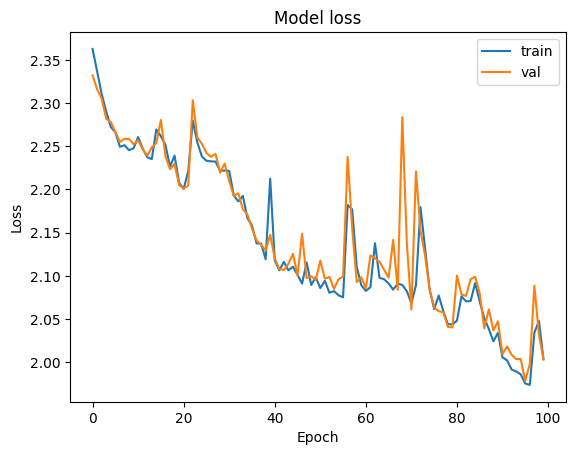

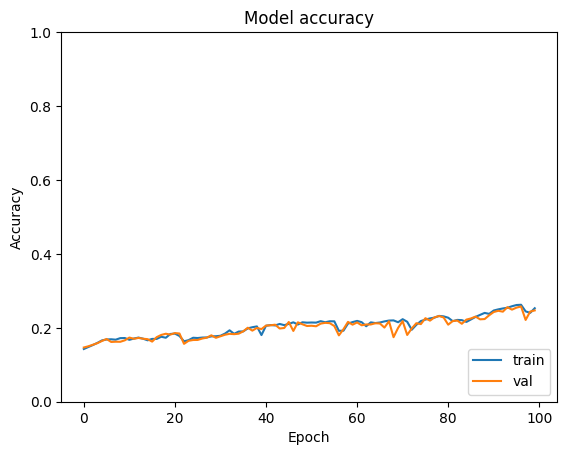

In [5]:
import matplotlib.pyplot as plt 
# 绘制训练loss和验证loss  
plt.plot(history.history['loss'], label='train')  
plt.plot(history.history['val_loss'], label='val')  
plt.legend(loc='upper right')  
plt.title('Model loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.show()  
  
# 绘制训练accuracy和验证accuracy  
plt.plot(history.history['accuracy'], label='train')  
plt.plot(history.history['val_accuracy'], label='val')  
plt.legend(loc='lower right')  
plt.title('Model accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.ylim(ymin=0, ymax=1)  # 设置y轴的范围为0到1  
plt.show()

# 评估模型效果

299/299 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step


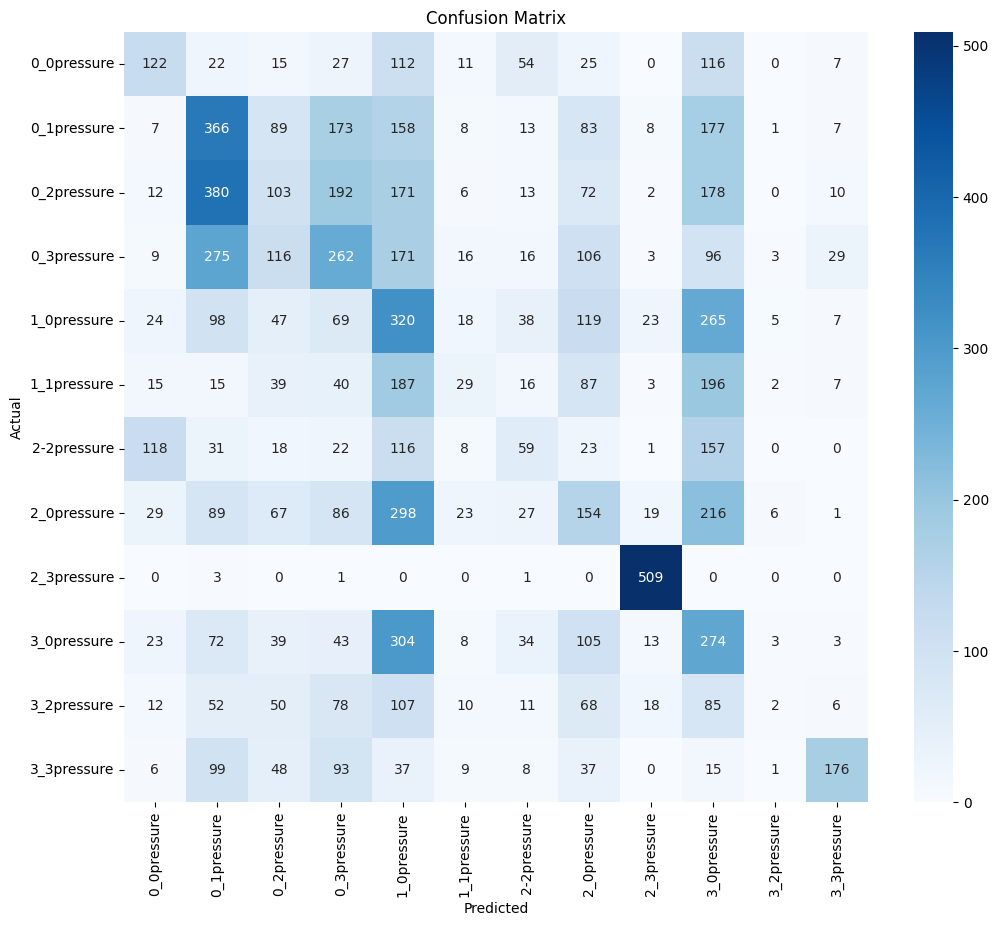

299/299 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.2487 - loss: 1.9933
Test loss: 1.9892
Test accuracy: 0.2490


In [6]:
from tensorflow.keras.models import load_model  
from sklearn.metrics import confusion_matrix  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
  
# # 加载模型  
# model = load_model("/kaggle/input/110spmlstm/keras/110spmlstm/1/model.h5")  
  
# 假设X_test和y_test是你的测试数据和真实标签（整数索引）  
# 这里需要你已经有了这些变量  
  
# 预测测试集  
y_pred = model.predict(X_test)  
# 对于多分类问题，使用argmax获取预测类别索引  
y_pred_classes = np.argmax(y_pred, axis=1)  
   
# 计算混淆矩阵  
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)  # 确保y_test也是索引形式  
  
# 获取所有唯一标签的列表，这些标签将对应于整数编码的索引  
class_names = label_encoder.classes_  

# 绘制混淆矩阵  
plt.figure(figsize=(12, 10))  
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)  
plt.ylabel('Actual')  
plt.xlabel('Predicted')  
plt.title('Confusion Matrix')  
plt.show()

# 评估模型  
loss, accuracy = model.evaluate(X_test, y_test)  
print(f'Test loss: {loss:.4f}')  
print(f'Test accuracy: {accuracy:.4f}')

In [7]:
from sklearn.metrics import f1_score, classification_report  
import numpy as np  
  
# 假设 X_test 和 y_test 已经是准备好的测试集数据和标签  
  
# 使用模型进行预测  
y_pred_probs = model.predict(X_test)  # 获取预测的概率  
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # 将概率转换为类别标签  
  
# 注意：如果你的 y_test 是one-hot编码的，你需要先将其转换为类别索引  
y_true_classes = np.argmax(y_test, axis=1)  # 假设 y_test 是one-hot编码的  
  
# 计算F1分数  
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # 使用加权平均来计算多类别的F1分数  
print(f'F1 Score: {f1:.4f}')  
  
# 计算精确率、召回率和F1分数的详细报告  
report = classification_report(y_true_classes, y_pred_classes)  
print(report)

299/299 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step
F1 Score: 0.2361
              precision    recall  f1-score   support

           0       0.32      0.24      0.27       511
           1       0.24      0.34      0.28      1090
           2       0.16      0.09      0.12      1139
           3       0.24      0.24      0.24      1102
           4       0.16      0.31      0.21      1033
           5       0.20      0.05      0.07       636
           6       0.20      0.11      0.14       553
           7       0.18      0.15      0.16      1015
           8       0.85      0.99      0.91       514
           9       0.15      0.30      0.20       921
          10       0.09      0.00      0.01       499
          11       0.70      0.33      0.45       529

    accuracy                           0.25      9542
   macro avg       0.29      0.26      0.26      9542
weighted avg       0.26      0.25      0.24      9542

